# Vertices for Hubbard atom

In [28]:
using Revise
using LinearAlgebra
using SparseIR
import SparseIR: valueim
using MSSTA
import MSSTA: QuanticsInd, quantics_to_index, asqubits, index_to_quantics, QubitInd, qubit_to_index, index_to_qubit
using OvercompleteIR
import OvercompleteIR: PHConvention, freq_box
import OvercompleteIR.Atom: HubbardAtom, MagneticChannel, chi0, full_vertex, gamma
using Plots
import TensorCrossInterpolation as TCI

newaxis = [CartesianIndex()]

1-element Vector{CartesianIndex{0}}:
 CartesianIndex()

In [29]:
using ITensors

In [50]:
U = 1.0
beta  = 10.0
ch = DensityChannel()
conv = PHConvention()
model = HubbardAtom(U, beta)

HubbardAtom(1.0, 10.0, 148.4131591025766, 0.25, 2.0134758939981707)

In [51]:
# TCI with R bits
function create_func(func, R)
    # Origin of frequency box
    origin = -2^(R-1)

    m = MSSTA.DiscreteMesh{3}(R, (origin, origin, origin))

    function q_to_n(q::Vector{QuanticsInd{3}})::NTuple{3, Int}
        return MSSTA.originalcoordinate(m, q)
    end

    function func_q(q::Vector{QuanticsInd{3}})::ComplexF64
        idx_3d = q_to_n(q)
        if iseven(idx_3d[1]) || iseven(idx_3d[2]) || isodd(idx_3d[3])
            return 0.0
        end
        return func((FermionicFreq(idx_3d[1]), FermionicFreq(idx_3d[2]), BosonicFreq(idx_3d[3])))
    end

    return q_to_n, func_q, m
end

R = 20
q2n, fq, mesh = create_func(w->gamma(ch, model, w), R)
;

In [52]:
fI = x->fq(QuanticsInd{3}.(x))
localdims = fill(8, R)

firstpivot = convert.(Int, index_to_quantics((2, 2, 1), R))
#fq(QuanticsInd{3}.(firstpivot))
@show fI(firstpivot)
firstpivot = TCI.optfirstpivot(fI, localdims, firstpivot)
@show fI(firstpivot)

fI(firstpivot) = 8.466535745565027 + 0.0im
fI(firstpivot) = 24.847097233489638 + 0.0im


24.847097233489638 + 0.0im

In [53]:
qtt, ranks, errors = TCI.crossinterpolate2(
    ComplexF64, fI, localdims,
    [firstpivot], tolerance=1e-8, maxiter=10, verbosity=1
)

(TensorCrossInterpolation.TensorCI2{ComplexF64} with rank 369, [8, 64, 369], [0.005152704277845794, 0.0011937652592402515, 1.3579896240784858e-10])

In [44]:
q_diagonal = [MSSTA.quanticsindex(mesh, (2, 2, 1) .+ i) for i in 0:2^(R-5):2^R-1]
reconst_diagonal = [TCI.evaluate(qtt, convert.(Int, q)) for q in q_diagonal]
ref_diagonal = fq.(q_diagonal)
;

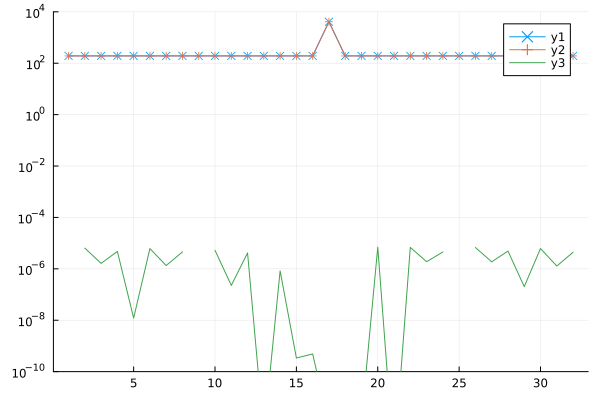

In [45]:
p = plot(yaxis=:log, ylims=(1e-10,1e+4))
plot!(p, abs.(reconst_diagonal), marker=:x)
plot!(p, abs.(ref_diagonal), marker=:+)
plot!(p, abs.(ref_diagonal .- reconst_diagonal))

In [46]:
f = collect(-101:2:101)
b = 2

is = collect(Iterators.product(f, f,  b))
ws = [MSSTA.meshindex(mesh, i) for i in is]
qs = [MSSTA.quanticsindex(mesh, w) for w in ws]

vals = [TCI.evaluate(qtt, convert.(Int, q)) for q in qs]
;

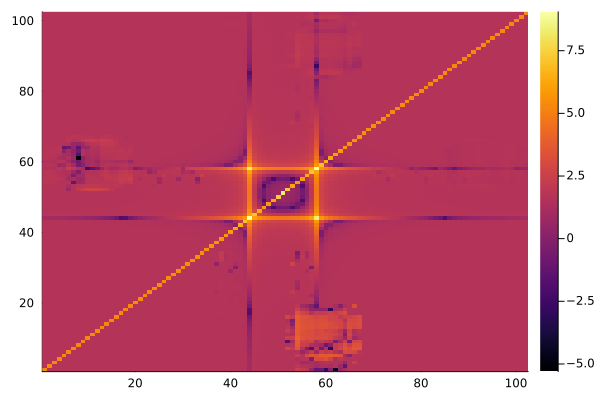

In [47]:
heatmap(log.(abs.(vals)))

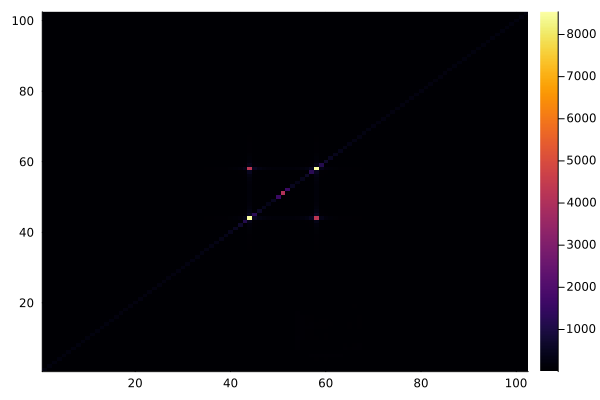

In [48]:
heatmap((abs.(vals)))

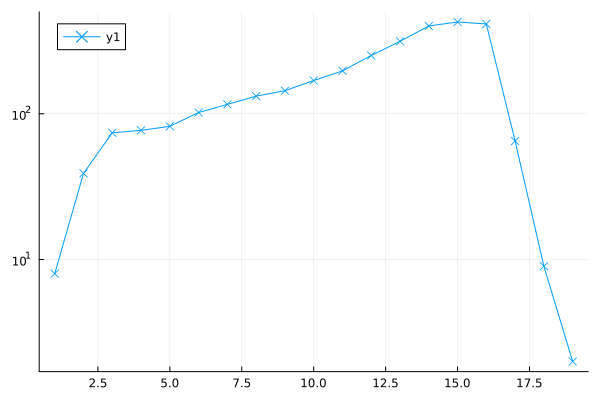

In [49]:
plot(TCI.linkdims(qtt), yaxis=:log, marker=:x)